In [20]:
import gym
import random
from keras import Sequential
# import tensorflow as tf
from collections import deque
from keras.layers import Dense
from keras.optimizers import adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear
import psutil
import gc

import numpy as np

In [21]:
env = gym.make('LunarLander-v2')
# Landing pad is always at coordinates (0,0). 
# Coordinates are the first two numbers in state vector. 
# Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. 
# If lander moves away from landing pad it loses reward back. 
# Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. 
# Each leg ground contact is +10. 
# Firing main engine is -0.3 points each frame. Solved is 200 points. 
# Landing outside landing pad is possible. 
# Fuel is infinite, so an agent can learn to fly and then land on its first attempt. 
# Four discrete actions available: do nothing, fire left orientation engine, fire main engine,
#     fire right orientation engine.

print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)
state_size = env.observation_space.shape[0]

Box(8,)
[inf inf inf inf inf inf inf inf]
[-inf -inf -inf -inf -inf -inf -inf -inf]


In [22]:
# # neural network architecture, input=states, output=actions
def build_model(input_size, output_size,lr = 0.001):
    model = Sequential()
    model.add(Dense(128, input_dim = input_size, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_size, activation = "linear"))
    model.compile(loss='mse', optimizer=adam(lr=lr))
    return model

![Explanation of environment exploration/exploitation] (https://github.com/VeronikaRevjakina/LunaLander_RL/blob/master/firefox_mQVLhQrl3o.png?raw=true)

[QL](https://www.freecodecamp.org/news/diving-deeper-into-reinforcement-learning-with-q-learning-c18d0db58efe)

In [23]:
def dql_train(env, state_size, action_size, model, train_games_num, max_steps_in_game,batch_size,discount_rate,
              epsilon=1.0,epsilon_decay = 0.99):
    counter = 0
    scores = np.array([])
    #object for remembering all things need for dql in memory
    memory = {"state":np.array([]), 
            "action":np.array([], dtype = int), 
            "reward":np.array([]),
            "new_state":np.array([]), 
            "done":np.array([])
            }
    for game in range(train_games_num):
        obs = env.reset() #to initial state
#         obs = obs.reshape([1,state_size]) # reshape for neural network input
        obs = np.reshape(obs, (1, state_size))
#         np.reshape(obs, (1, state_size))
#         obs = np.reshape(obs, (1, state_size))
        game_score = 0
        
        for step in range(max_steps_in_game):  
            # get an action number random or model
            if np.random.rand() <= epsilon:
                action =int(random.randrange(action_size))  # get random because explore env
            else:
#                 act_values = model(obs) # model predict based on state
#                 action = int(np.argmax(act_values[0]))
                action = np.argmax(model.predict(obs)[0])
#             env.render()
            # take an action
            new_obs, reward, done, info = env.step(action)
#             new_obs = new_obs.reshape([1,state_size]) # reshape for neural network input
            new_obs = np.reshape(new_obs, (1, state_size))
            game_score += reward
        
            #  remember into memory this step
            if len(memory["state"])>0:
                memory["state"] = np.vstack((memory["state"], obs)) # to get matrix of row = state vector of 8 values
                memory["new_state"] = np.vstack((memory["new_state"], new_obs))
            else:
                memory["state"] = np.array(obs) # if not initialized new
                memory["new_state"] = np.array(new_obs)
            memory["action"] = np.append(memory["action"], action)  # just vectors
            memory["reward"] = np.append(memory["reward"], reward)
            memory["done"] = np.append(memory["done"], done)

            obs = new_obs  # change to new state
            
            # if we get data for batch then update model weights with earned data, clear it and start again:
            if len(memory["state"])>=batch_size:
                # randomly sample batch from memory with 64 size always
                indexes = np.random.randint(len(memory["done"]), size=batch_size)
                batch = {
                    "state": np.squeeze(memory["state"][indexes]), 
                    "action": memory["action"][indexes], 
                    "reward": memory["reward"][indexes], 
                    "new_state": np.squeeze(memory["new_state"][indexes]), 
                    "done": memory["done"][indexes]
                    }
                # Bellman's equation for target only for chosen actions, 
                #(1-done) to discard cumilative gain for last actions
                targets = batch["reward"] + \
                        discount_rate*(np.amax(model.predict_on_batch(batch["new_state"]), axis=1))*(1-batch["done"])
                targets_full = model.predict_on_batch(batch["state"])  # needed to fill counted above target 
                # on performed actions, rest stays as model counted
#                 targets_full[np.array(range(batch_size)), batch["action"]] = targets # change specific indexes
                ind = np.array([i for i in range(batch_size)])
                targets_full[[ind], batch["action"]] = targets
                model.fit(batch["state"], targets_full, epochs = 1, verbose = 0)
                
                if epsilon > 0.01:
                      epsilon *= epsilon_decay  # update exploration/exploitation parameter

            if done: # from step performed
                print(f'game {game}, performed steps {step}, score {game_score}, counter positive {counter}')
                break

        scores = np.append(scores, game_score)
        
        if game_score < 0:
            counter = 0
            continue
      #more than 0
        counter += 1
        if np.mean(scores[-100:])>= 220: # mean of latest 100 games more than 220
            print(f"Evaluate in {game+1} iterations")
            break
    
    return scores, model
            

In [24]:
games_iter = 1000
num_iter = 1000
discount_rate = 0.99  # how much depend on long time reward
batch_size = 64  # for sampling from memory, training 
action_size =4 # fixed for environment

model = build_model(state_size, action_size)  #get model of architecture above

traning_score, trained_model = dql_train(env,state_size,action_size, model, games_iter,num_iter,batch_size,discount_rate)
trained_model.save('trained_model2.h5')

game 0, performed steps 72, score -87.80050734429338, counter positive 0
game 1, performed steps 194, score -223.81923255810827, counter positive 0
game 2, performed steps 70, score -279.71306796585236, counter positive 0
game 3, performed steps 85, score -297.08316915109026, counter positive 0
game 4, performed steps 68, score -159.40748333332726, counter positive 0
game 5, performed steps 129, score -104.65675943628335, counter positive 0
game 6, performed steps 62, score -31.757499963032004, counter positive 0
game 7, performed steps 527, score 218.90525760625977, counter positive 0
game 8, performed steps 132, score -350.05179247992083, counter positive 1
game 9, performed steps 107, score -437.4858362832581, counter positive 0
game 10, performed steps 145, score -237.62037625464205, counter positive 0
game 11, performed steps 97, score -241.26083206565488, counter positive 0
game 12, performed steps 259, score -90.87991364533082, counter positive 0
game 13, performed steps 146, sc

game 110, performed steps 536, score 241.5680808561826, counter positive 1
game 111, performed steps 498, score 182.8401687260522, counter positive 2
game 112, performed steps 496, score -173.46557246774336, counter positive 3
game 113, performed steps 999, score 41.63747054469227, counter positive 0
game 114, performed steps 895, score 89.1250048459378, counter positive 1
game 115, performed steps 748, score -154.13552856610502, counter positive 2
game 116, performed steps 999, score -55.62835883657632, counter positive 0
game 117, performed steps 630, score -341.8520611610461, counter positive 0
game 118, performed steps 357, score 211.04312036868936, counter positive 0
game 119, performed steps 409, score 271.2829006075248, counter positive 1
game 120, performed steps 452, score 224.90244605317605, counter positive 2
game 121, performed steps 545, score 240.84444153887202, counter positive 3
game 122, performed steps 573, score 184.7872758189709, counter positive 4
game 123, perform

game 218, performed steps 244, score 267.08176877487983, counter positive 30
game 219, performed steps 204, score 270.260903955026, counter positive 31
game 220, performed steps 255, score 299.2034608221785, counter positive 32
game 221, performed steps 293, score 284.3747034377768, counter positive 33
game 222, performed steps 218, score 276.98227206348145, counter positive 34
game 223, performed steps 354, score 267.9178393090891, counter positive 35
game 224, performed steps 336, score 278.5852411484261, counter positive 36
game 225, performed steps 232, score 268.1480296199537, counter positive 37
Evaluate in 226 iterations


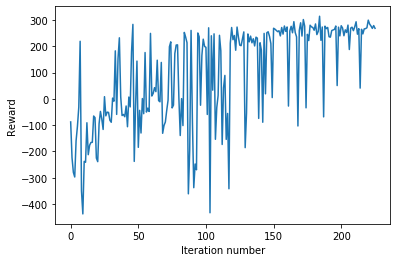

In [25]:
x=list(range(len(traning_score)))
plt.plot(x, traning_score)
plt.xlabel("Iteration number")
plt.ylabel("Reward")
plt.show()

In [26]:
from keras.models import load_model
model = load_model('trained_model2.h5')

In [27]:
test_games_num = 100
test_scores = []
max_steps_in_game = 1000
for game in range(test_games_num):
    score = 0
    obs = env.reset()  # get initial state
    for step in range(max_steps_in_game):
#         env.render()  # show gif
#         print(observation)  # print state vector 8, fixed for environment
        obs = np.reshape(obs, (1, state_size))
        rewards = trained_model.predict(obs)
        action = int(np.argmax(rewards[0]))
#         action = env.action_space.sample()
        obs, reward, done, info = env.step(action)  # step returns 4 parameters
        score +=reward
        if done:  # game over need reset
#             print("Episode finished after {} timesteps".format(step+1))
            print(score)
            break
    test_scores.append(score)

237.84729672941415
-109.1525081855993
-65.71569005514803
300.85726053171516
-55.83030836268901
276.4079718239584
32.81149669691783
318.35019131213244
300.83843042621135
36.01161797557515
34.125808677422725
270.70378555189416
-28.242867745140458
207.90345223421883
40.37010197010153
292.0541694771673
259.4800781621571
-37.122740268565465
298.9539650609661
63.63222007948289
53.198384669475644
57.11114394665438
-67.27710053273404
301.48274053731274
-39.80537832713458
30.928604123704986
57.803655316613
247.90136565295816
-53.58520689828878
244.67305763370524
292.35780857409316
35.45734860682413
296.78154769584035
231.54042165368085
241.97214619661239
65.79048669053563
45.85159515304366
193.40783921654491
-3.62233764837751
297.51063183792974
-26.520776853819314
-36.535063383398494
55.0351119631714
25.670565278762766
-11.248852354894382
-4.290935371588063
-32.443695967002114
215.4071575740508
303.22752366453255
11.799669179476922
61.966040155652394
178.21769364132277
243.92091286563615
-64.39

In [28]:
print("Average reward on test 100 games: ", np.mean(test_scores))

Average reward on test 100 games:  117.1330471138595


In [29]:
test_scores = np.array(test_scores)
print("Number of games in 100 where reward")
print("less than 0: ", len(test_scores[test_scores<0]))
print("equals 0: ", len(test_scores[test_scores==0]))
print("more than 0: ", len(test_scores[test_scores>0]))
print("equals or more than 100: ", len(test_scores[test_scores>=100]))
print("equals or more than 200: ", len(test_scores[test_scores>=200]))

Number of games in 100 where reward
less than 0:  30
equals 0:  0
more than 0:  70
equals or more than 100:  44
equals or more than 200:  42
